In [30]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
import json
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import pyrallis

from src.optics.channel_simulation2 import ChannelSimulator2
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import MainConfig


# Channel Simulation
here starts the actual channel simulator code.

In [32]:
conf = MainConfig(
    W = 0.05,             # Total bandwidth, estimated [THz]
    Nspans = 12,            # The number of spans
    span_length = 80,       # Transmission span [km]
    M_QAM = 64,             # QAM order (2,4,16,64,256)
    Ts = 1,               # Symbol period [??]

    # Modulation and Coding:
    Nos = 16,               # Oversampling factor (must be even)
    eta = 2,                # spectral efficiency penalty factor (1,4]
    mu = 0.1,             # Dimensionless power scaling factor (RRC)
    bet = 0.2,            # roll-off factor
    with_ssf = True,       # whether to use SSF or not
    with_noise = True,     # whether to add noise or not

    # Fiber and Dispersion:
    alphadB = 0.2,        # Power loss db/km
    beta2 = -21,          # ps^2/km
    gamma = 1.27,         # Nonlinear coefficient in [1/km*W]
    dz = 0.2,             # Z-step, [km] - initial step estimate
)

In [33]:
cs = ChannelSimulator2(conf)


In [34]:
print('conf')
print(cs.configs)

conf
ChannelConfig(input_generator_config=InputGeneratorConfig(M_QAM=64, N_sc=256), modulator_config=ModulatorConfig(M_QAM=64), over_sampler_config=OverSamplingConfig(N_os=16), spectral_shaping_config=SpectralShaperConfig(bet=0.2, Ts=1, Nos=16), pre_equalizer_config=PreEqualizerConfig(mu=0.1, span_length=80, Zn=87833.13612677579), inft_config=INFTConfig(Pn=3.387832219149323e-05), ssf_config=SSFConfig(beta2=-21, gamma_eff=0.3360622388307512, T0=5120.0, dz=0.2, span_length=80, with_ssf=True, with_noise=True, Pn=3.387832219149323e-05), nft_config=NFTConfig(), post_equalizer_config=PostEqualizerConfig(Zn=87833.13612677579, mu=0.1, span_length=80, with_ssf=True), match_filter_config=MatchFilterConfig(Nos=16, bet=0.2, Ts=1), decoder_config=DecoderConfig(M_QAM=64), evaluator_config=EvaluatorConfig(M_QAM=64, N_sc=256))


In [35]:
print('extra inputs:')
print(cs.extra_inputs)

extra inputs:
{'xi': array([-128.    , -127.9375, -127.875 , ...,  127.8125,  127.875 ,
        127.9375]), 'xi_padded': array([-511.9375, -511.875 , -511.8125, ...,  511.875 ,  511.9375,
        512.    ]), 't': array([-5120.83333333, -5116.66666667, -5112.5       , ...,
        5108.33333333,  5112.5       ,  5116.66666667]), 't_padded': array([-25.13274123, -25.12967327, -25.12660531, ...,  25.12353734,
        25.12660531,  25.12967327]), 'Nnft': 16384, 'Nb': 2458, 'Ns': 4096, 'dt': 4.166666666666667}


In [36]:
x0 = cs.block0.execute()
Visualizer.vec2str(x0,4,2)

'[15, 12, 49, 57, ... ,22, 43]'

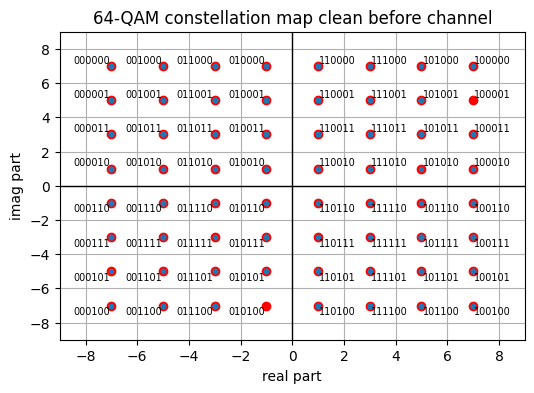

In [37]:
x1 = cs.blocks[0].execute(x0, None)
Visualizer.plot_constellation_map_with_points(x1, conf.M_QAM, 'clean before channel')


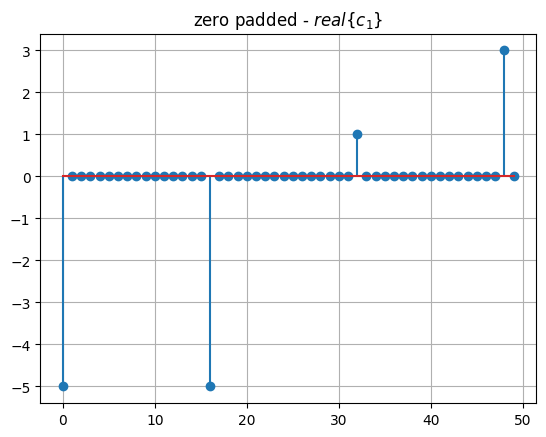

In [38]:
x2 = cs.blocks[1].execute(x1, None)
Visualizer.my_plot(range(50), np.real(x2[0:50]), name='zero padded - $ real\{c_1 \} $', function='stem')

length of x3: 4096
length of xi: 4096


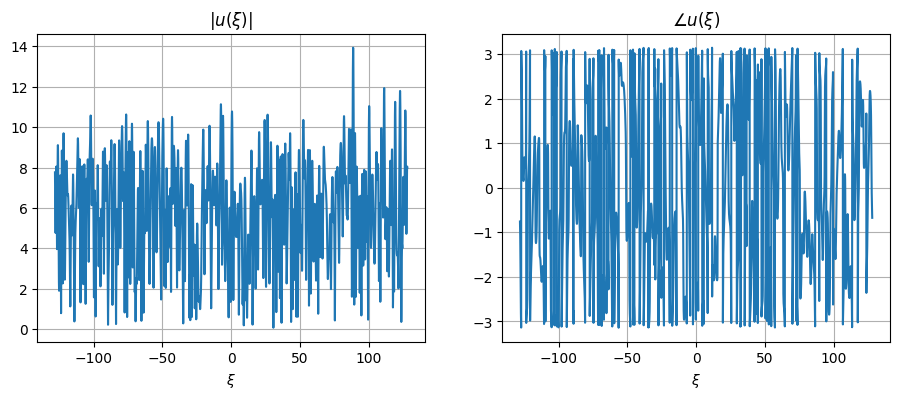

In [39]:
x3 = cs.blocks[2].execute(x2, None)
# Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(cs.blocks[2].psi_xi) ** 2, zm, h_ind, xlabel=r'$\xi$')
xi = cs.extra_inputs['xi']
print(f'length of x3: {len(x3)}')
print(f'length of xi: {len(xi)}')
Visualizer.plot_amp_and_phase(xi,x3,r'$\xi$',r'u(\xi)')

length of x4: 16384


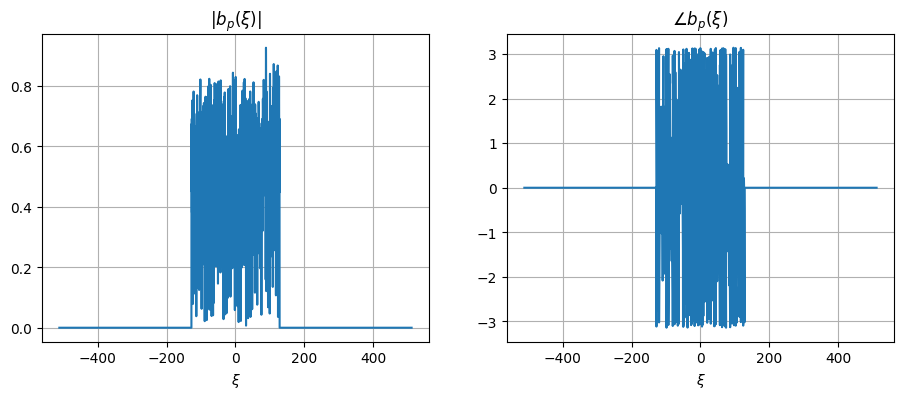

In [40]:
x4 = cs.blocks[3].execute(x3, None)
print(f'length of x4: {len(x4)}')
xi_padded = cs.extra_inputs['xi_padded']
Visualizer.plot_amp_and_phase(xi_padded,x4, r'$\xi$', r'b_p(\xi)')


length of x5: 2458
length of t: 2458


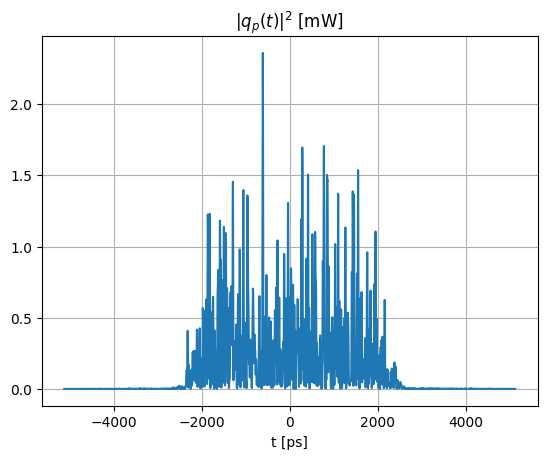

In [41]:
x5 = cs.blocks[4].execute(x4, None)
print(f'length of x5: {len(x5)}')
t = cs.extra_inputs['t']
print(f'length of t: {len(t)}')
power_q_mw = np.abs(x5)**2*1e3 # power in [mW]
Visualizer.my_plot(t, power_q_mw, name=r'$|q_p(t)|^2$ [mW]', xlabel='t [ps]')


length of x6: 16384
 Nnft = 16384
pads = 6963
Pn = 3.387832219149323e-05
length of t_padded: 16384


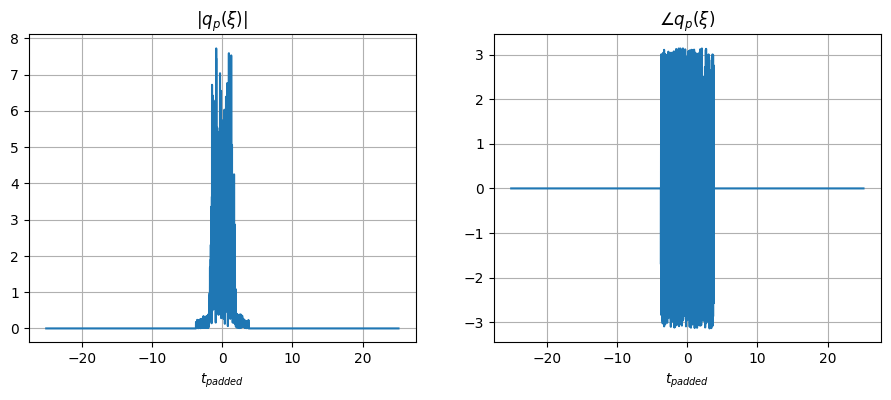

In [42]:
x6 = cs.blocks[5].execute(x5, None)
print(f'length of x6: {len(x6)}')
print(f' Nnft = {cs.extra_inputs["Nnft"]}')
print(f'pads = {cs.blocks[5].pads}')
print(f'Pn = {cs.blocks[5].Pn}')
t_padded = cs.extra_inputs['t_padded']
print(f'length of t_padded: {len(t_padded)}')
Visualizer.plot_amp_and_phase(t_padded, x6, r'$t_{padded}$', r'q_p(\xi)')

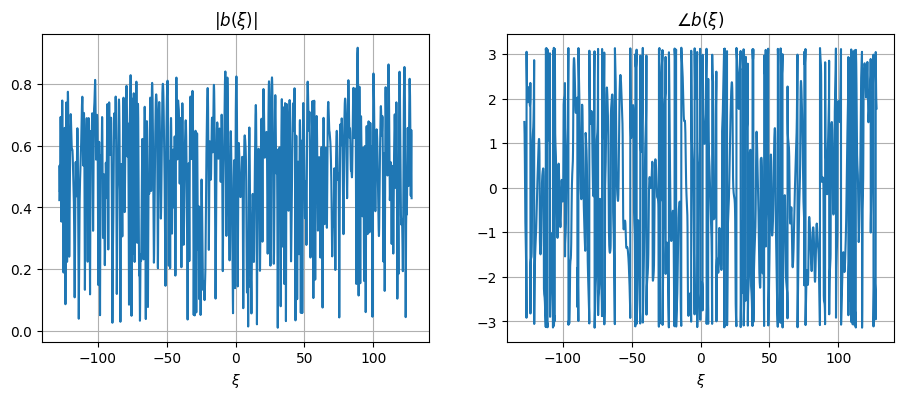

In [43]:
x7 = cs.blocks[6].execute(x6, None)

Visualizer.plot_amp_and_phase(xi, x7, r'$\xi$', r'b(\xi)')

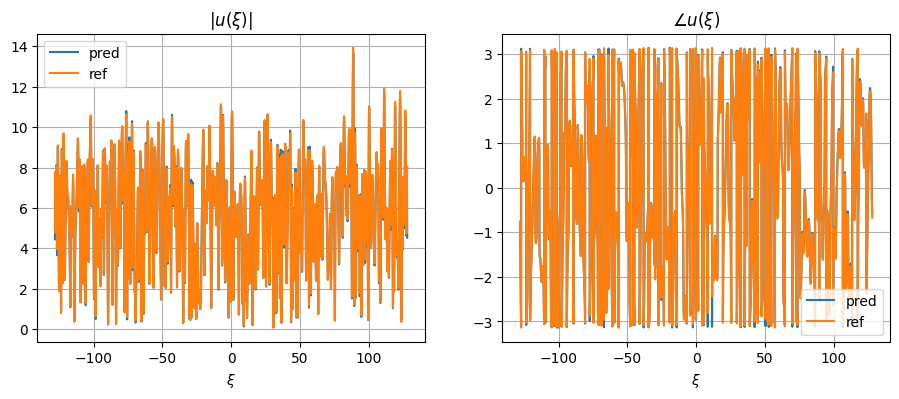

In [44]:
x8 = cs.blocks[7].execute(x7, None)

Visualizer.compare_amp_and_phase(xi,x8, x3, r'$\xi$', r'u(\xi)', "")

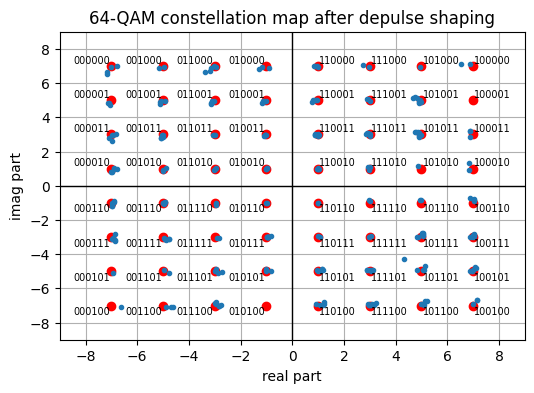

In [45]:
x9 = cs.blocks[8].execute(x8, None)

M_QAM = conf.M_QAM
Visualizer.plot_constellation_map_with_points(x9, M_QAM, 'after depulse shaping')


In [46]:
x10 = cs.blocks[9].execute(x9, None)

sps = np.log2(M_QAM)

x10

array([0., 0., 1., ..., 0., 1., 1.])

In [47]:
org_bins = cs.blocks[0].get_outputs()[0]


In [49]:
cs.block11.calc_ber(x10,cs.blocks[0].get_outputs()[0])

ber = 0.0 = 0/1536.0


(0, 0.0)